In [1]:
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from  keras.layers import Conv2D,Dropout,Flatten,Dense,MaxPooling2D,BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import TensorBoard

# fashion-mnist pre-shuffled train and test data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
train_res = {}   
logdir = "logs/"
tensorboard_callback = TensorBoard(log_dir=logdir)


Using TensorFlow backend.


Fashion-mnist dataset sample


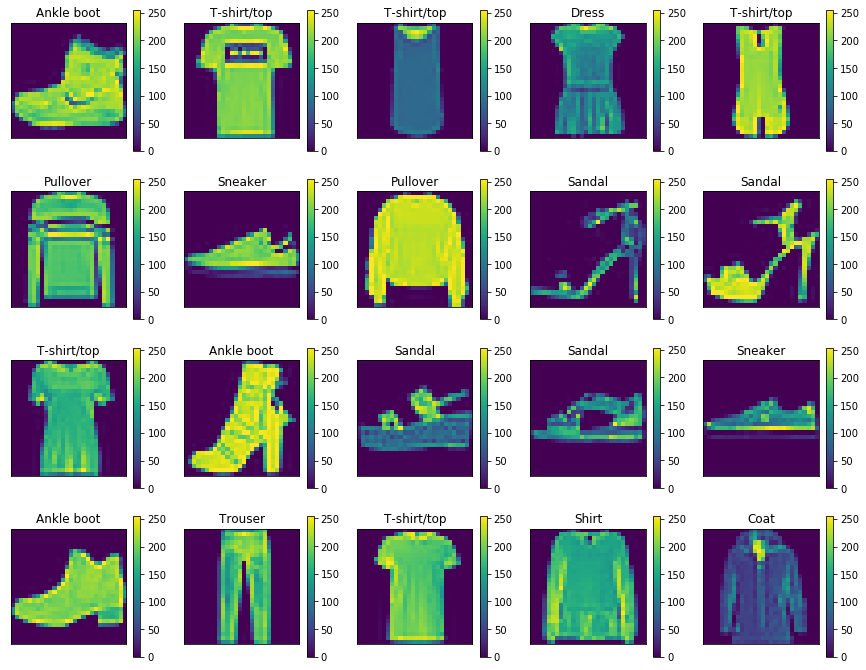

In [2]:
print("Fashion-mnist dataset sample")

plt.figure(figsize=(15,15))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(train_images[i] )
    plt.title( labels[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.grid(False)
plt.show()



## **Pre-processing the data**

As part of pre-processing the data, following techniques were applied on the dataset:

#### 1). Create validation & test data sets
I split the train data(*60.000* samples) into *10.000* samples for the validation which is used for tuning the parameters of a model to ensure the model generalizing well. Model use *50.000* samples for training set and *10.000* for test data to evaluate model performance on unseen data.  

#### 2). Normalization
Images color data scales between 0-255 which is quite large, hence we should normalize image data to fit in scale 0-1 to to make our network easier to train.

#### 3). Reshaping images
We’ll reshape each image from (28, 28) to (28, 28, 1) because CNN requires the third dimension.


-----------------------------------------------------------------------------
Summary
train data:      (50000, 28, 28) , train data labels:       (50000,) 
test data:       (10000, 28, 28) , test data labels:        (10000,) 
validation data: (10000, 28, 28)  , validation data labels:  (10000,) 
-----------------------------------------------------------------------------

Standartized Input Images



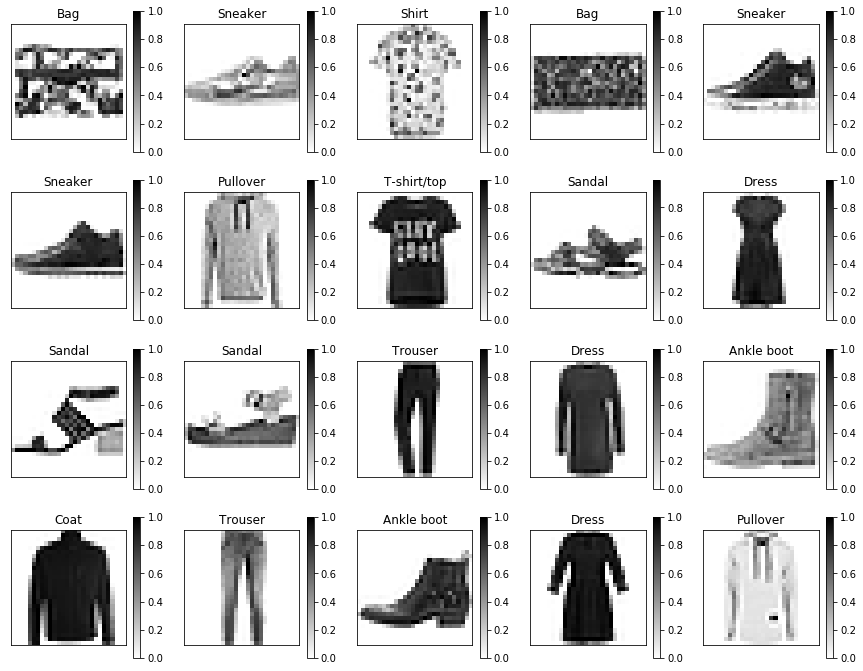

In [3]:
#splitting validation data
train_images, train_labels=train_images[10000:], train_labels[10000:]
valid_images, valid_labels=train_images[:10000], train_labels[:10000]


# [0-255] -> [0-1]
#train_images= tf.keras.utils.normalize(train_images,axis=1)
train_images= train_images / 255.0
test_images= test_images / 255.0
valid_images= valid_images  / 255.0

num_label_class = len(labels)

print()  
print("-----------------------------------------------------------------------------")    
print("Summary")    
print("train data:      %s , train data labels:       %s " % (train_images.shape, train_labels.shape))
print("test data:       %s , test data labels:        %s " % (test_images.shape, test_labels.shape))
print("validation data: %s  , validation data labels:  %s " % (valid_images.shape, valid_labels.shape)) 
print("-----------------------------------------------------------------------------")    
print()  
print("Standartized Input Images")
print()    

# Images color scale after normalization process:
plt.figure(figsize=(15,15))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.title( labels[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.grid(False)
plt.show()    


train_images = train_images.reshape(train_images.shape[0],28,28,1)
test_images = test_images.reshape(test_images.shape[0],28,28,1)
valid_images = valid_images.reshape(valid_images.shape[0],28,28,1)



## CNN Model Architecture

CNN model  has 3 convolutional layers, 2 max pool layers,  1 fully connected (dense) layers and 1 output (softmax) layer. 
 
- Conv2D layers with 3x3 feature map size. Input convolution layer has 64 neurons. increasing neurons in the next layers is an important notion to increase accuracy.
- MaxPooling2D,downsampling, to get the most important(max) information from each feature map.
- 1 fully connected layers with  128 neurons.
   Adding a fully-connected(dense) layer before output layer is a common usage since dense layer classify images based on the high features extracted by previous layer. Best practice to determine dense layer neuron number is to equalize the number of the latest convolutional layer neurons.
- 1 output layer with a softmax activation function to obtain classification probabilities(total sum of the probabilities of 10 classes equals to one)


While building a deep learning model, one of the main concern is **over-fitting**. CNN models are prone to *over-fitting*. Overfitting means that model memorize what it should do with each input instead of learning the general concepts of the data. Therefore it performs much better on the training set than validation dataset. It may detectable by observing big difference between validation loss and training loss or test accuracy is much lower than validation accuracy.

There are multiple preventing methods like dropout or regularization. My model use **L2 regularization** to  arrive at a better generalized model. l2_loss_lambda hyperparameter selected as 0.00015.

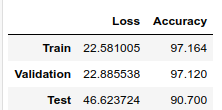

In [4]:
from IPython.display import display, Image
display(Image(filename='imgs/overfitting_acc.png'))

The difference between the training accuracy & validation accuracy (~7%) shows that model is still over-fitting the training data so I decided to combine dropout & l2 regularization. L2 regularization & dropout increased loss slightly but able to prevent over-fitting with a great accuracy. 

More convolution and pooling layers added to final model also to increase accuracy by extracting more features.
Below is the architecture of my final CNN model.


### Build

In [5]:
Regularizer = l2(0.00015)
cnn_model_3 = Sequential([Conv2D(64, kernel_size=3, activation='relu', padding='same',
                                 kernel_regularizer=Regularizer, input_shape=(28,28,1)),
                          
                         Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer=Regularizer),
                         MaxPooling2D(pool_size=2),
                         Dropout(0.25),

                         Conv2D(128, kernel_size=3, activation='relu', kernel_regularizer=Regularizer),
                         MaxPooling2D(pool_size=2),
                         Dropout(0.3),

                         Flatten(),
                         Dense(128, activation='relu', kernel_regularizer=Regularizer),
                         Dropout(0.3),
                         Dense(10, activation='softmax')

                         ],name="CNN Model")
cnn_model_3.summary()

Model: "CNN Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 128)         0 

 ### Compile
Since the target labels are integers(0 - T-shirt/top, 1 -Trouser etc) , I use sparse_categorical_crossentropy and Adam optimization algorithm with default learning rate(0.0001) which is pretty stable.


In [6]:
cnn_model_3.compile(loss='sparse_categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

### Train

In [7]:
batch_size=128
epochs=20
      
train_res["CNN Model"] = cnn_model_3.fit(train_images,train_labels ,batch_size=batch_size, epochs=epochs,
                            validation_data=(valid_images,valid_labels),
                            verbose=2,
                            shuffle=True,#over-fitting prevention   
                            callbacks=[tensorboard_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 70s - loss: 0.6576 - accuracy: 0.7781 - val_loss: 0.4304 - val_accuracy: 0.8600
Epoch 2/20
 - 68s - loss: 0.4418 - accuracy: 0.8605 - val_loss: 0.3460 - val_accuracy: 0.8929
Epoch 3/20
 - 70s - loss: 0.3917 - accuracy: 0.8813 - val_loss: 0.3434 - val_accuracy: 0.8980
Epoch 4/20
 - 70s - loss: 0.3691 - accuracy: 0.8914 - val_loss: 0.3055 - val_accuracy: 0.9140
Epoch 5/20
 - 68s - loss: 0.3522 - accuracy: 0.8987 - val_loss: 0.3027 - val_accuracy: 0.9122
Epoch 6/20
 - 65s - loss: 0.3392 - accuracy: 0.9032 - val_loss: 0.2821 - val_accuracy: 0.9260
Epoch 7/20
 - 65s - loss: 0.3321 - accuracy: 0.9063 - val_loss: 0.2800 - val_accuracy: 0.9297
Epoch 8/20
 - 66s - loss: 0.3258 - accuracy: 0.9107 - val_loss: 0.2686 - val_accuracy: 0.9278
Epoch 9/20
 - 65s - loss: 0.3227 - accuracy: 0.9125 - val_loss: 0.2745 - val_accuracy: 0.9315
Epoch 10/20
 - 65s - loss: 0.3133 - accuracy: 0.9164 - val_loss: 0.2633 - val_accuracy: 0.9315
Epoch 11/

### Evaluate

In [8]:
import pandas as pd
from IPython.display import display

test_loss_3, test_acc_3  = cnn_model_3.evaluate(test_images,test_labels, verbose=2)
train_loss_3, train_acc_3  = cnn_model_3.evaluate(train_images,train_labels, verbose=2)
val_loss_3, val_acc_3  =  cnn_model_3.evaluate(valid_images,valid_labels, verbose=2)


df = pd.DataFrame([[train_loss_3 * 100, train_acc_3 * 100],[val_loss_3 * 100, val_acc_3 * 100], 
                   [ test_loss_3 * 100, test_acc_3 * 100]], 
                   ["Train", "Validation","Test"],["Loss","Accuracy"])
display(df)

,Loss,Accuracy
Train,22.949519,95.424002
Validation,23.246547,95.150000
Test,31.936128,92.030001


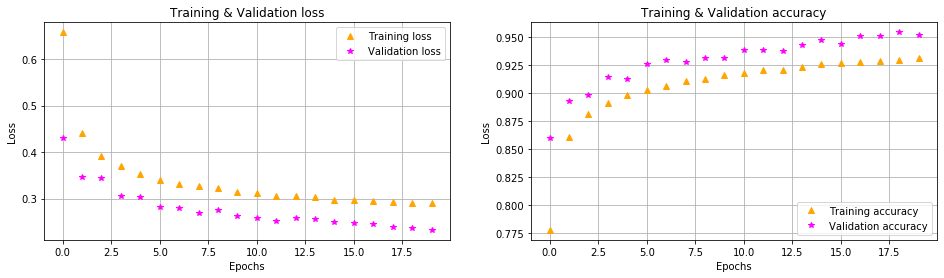

<Figure size 432x288 with 0 Axes>

In [13]:
%matplotlib inline

def helper_plt(col,val,training_val,valid_val):
    xy[col].plot(epochs, training_val, color='orange', marker='^', linestyle=' ', label='Training %s' % val)
    xy[col].plot(epochs, valid_val, color='magenta', marker='*', linestyle=' ', label='Validation %s' % val)
    xy[col].set_title('Training & Validation %s' % val)
    xy[col].legend()
    xy[col].set_xlabel('Epochs')
    xy[col].set_ylabel('Loss')
    xy[col].grid(True)
    
model= cnn_model_3
acc = train_res[model.name].history['accuracy']
val_accuracy = train_res[model.name].history['val_accuracy']
train_loss = train_res[model.name].history['loss']
val_loss = train_res[model.name].history['val_loss']
epochs = range(len(acc))
f, xy = plt.subplots(nrows=1, ncols=2,figsize=((16, 4)))
helper_plt(0,"loss",train_loss,val_loss)
plt.figure()
helper_plt(1,"accuracy",acc,val_accuracy)
plt.show()


### Report

In [16]:
from sklearn.metrics import classification_report
from keras.utils import np_utils
import numpy as np

#prediction
predictions = cnn_model_3.predict(test_images)
test_labels_vec = np_utils.to_categorical(test_labels, 10)

# classification_report
print(classification_report(test_labels_vec.argmax(axis=-1), predictions.argmax(axis=1),target_names=labels))



              precision    recall  f1-score   support

 T-shirt/top       0.85      0.89      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.86      0.91      0.88      1000
       Dress       0.90      0.95      0.92      1000
        Coat       0.90      0.86      0.88      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.81      0.72      0.76      1000
     Sneaker       0.97      0.95      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.95      0.97      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



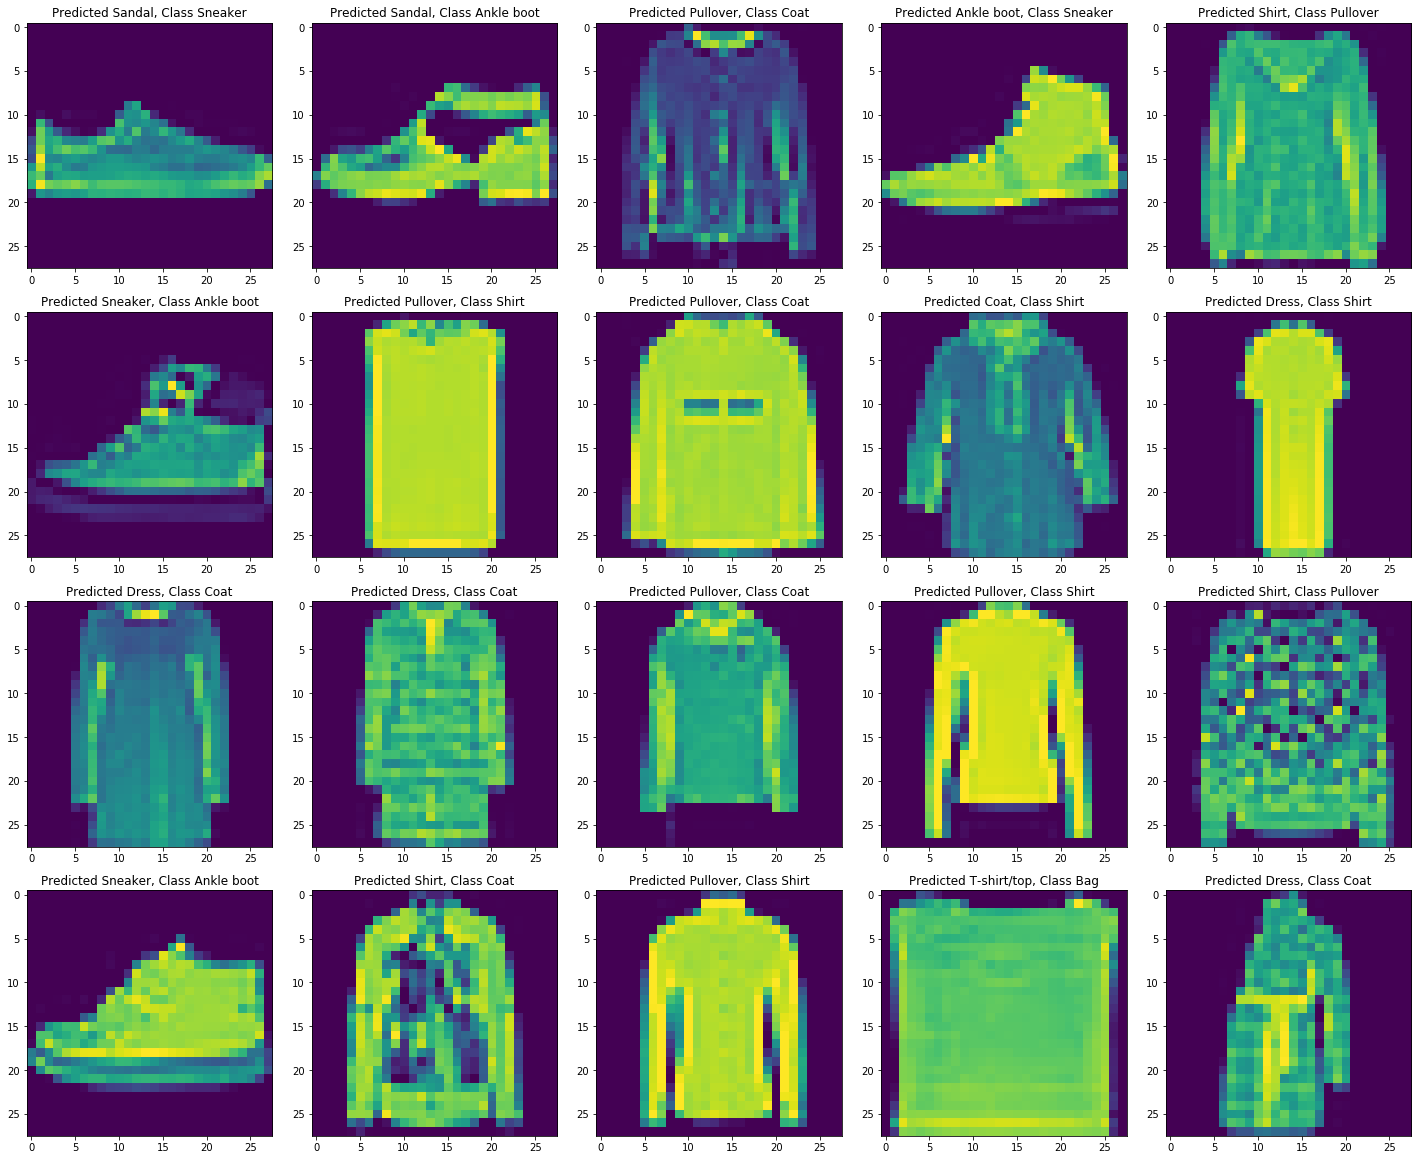

In [18]:
# Incorrect predictions and real labels
corrects = np.nonzero(np.argmax(predictions, axis=1)==test_labels)[0]
incorrects = np.nonzero(np.argmax(predictions, axis=1)!=test_labels)[0]

plt.figure(figsize=(20,20))
for i, incorrect in enumerate(incorrects[0:20]):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[incorrect].reshape(28,28))
    plt.title("Predicted {}, Class {}".format(labels[predictions.argmax(axis=1)[incorrect]], labels[test_labels_vec.argmax(axis=-1)[incorrect]]))
    plt.tight_layout()


In [19]:
#%load_ext tensorboard
#%tensorboard --logdir logs/  --port=6006 --host=0.0.0.0
#You may play with TensorFlow Graph to examine model’s structure 

Model Graph


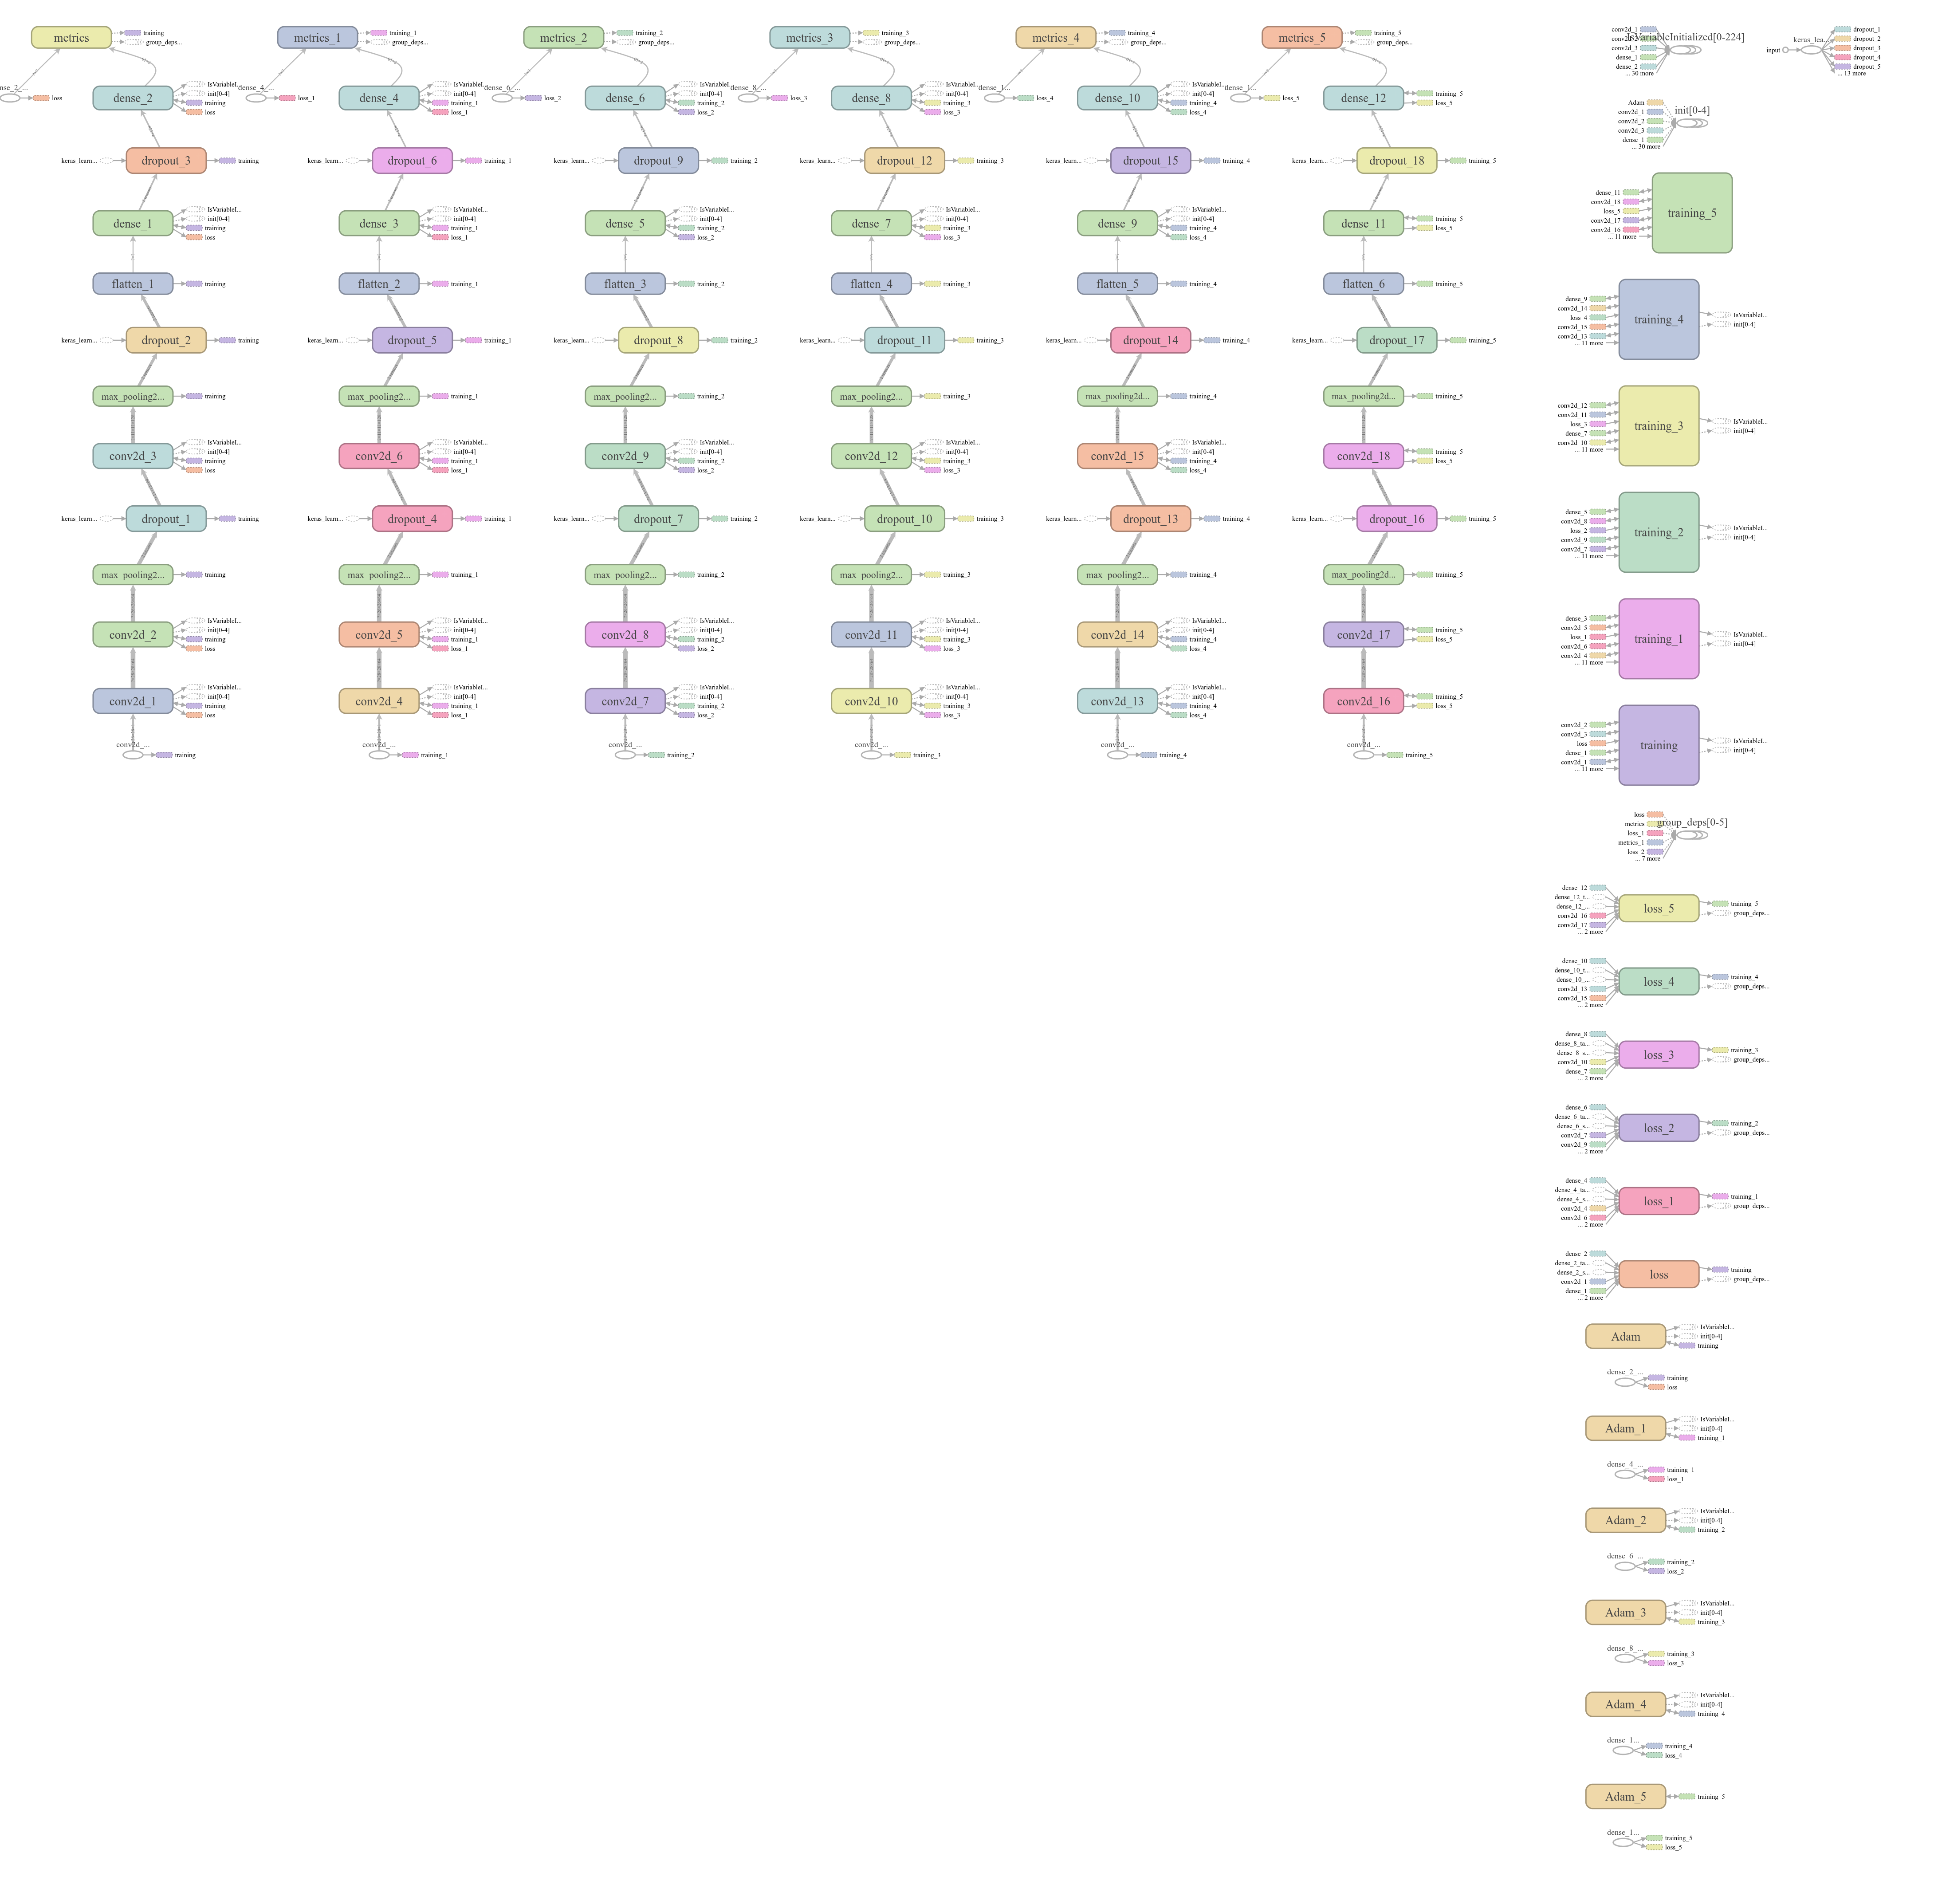

In [20]:
from IPython.display import display, Image
display(Image(filename='imgs/model.png'))
